In [2]:
import astropy
import astropy.io.votable as vot
import astropy.coordinates

import numpy
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline  

In [3]:
percentilefromsigma = lambda x : 0.5*(1+scipy.special.erf(x/numpy.sqrt(2)))*100
sigma2frac = lambda x : 0.5*(1.-scipy.special.erf(x/numpy.sqrt(2)))

In [4]:
data = vot.parse_single_table("perseus_redshifts.vot")
print data.fields
print data.array.shape

[<FIELD ID="main_col1" datatype="int" name="No." ucd="meta.number" width="4"/>, <FIELD ID="main_col2" arraysize="30" datatype="char" name="Object Name" ucd="meta.id;meta.main" width="30"/>, <FIELD ID="main_col3" datatype="double" name="RA(deg)" ucd="pos.eq.ra;meta.main" unit="degrees" width="10"/>, <FIELD ID="main_col4" datatype="double" name="DEC(deg)" ucd="pos.eq.dec;meta.main" unit="degrees" width="10"/>, <FIELD ID="main_col5" arraysize="*" datatype="char" name="Type" ucd="src.class" width="10"/>, <FIELD ID="main_col6" datatype="double" name="Velocity" ucd="src.veloc.hc" unit="km / s" width="10"/>, <FIELD ID="main_col7" datatype="double" name="Redshift" ucd="src.redshift" width="10"/>, <FIELD ID="main_col8" arraysize="*" datatype="char" name="Redshift Flag" ucd="meta.code;src.redshift" width="5"/>, <FIELD ID="main_col9" arraysize="*" datatype="char" name="Magnitude and Filter" ucd="meta.code;src.magnitude" width="5"/>, <FIELD ID="main_col10" datatype="double" name="Distance (arcmin)

In [5]:
redshift = data.array['Velocity']
delta_v = 4000
central_v = 5350
v_min = central_v-delta_v
v_max = central_v+delta_v
in_redshift_range = (redshift > v_min) & (redshift < v_max)
print "Redshift limits:", central_v-delta_v, central_v+delta_v

ra = data.array['RA(deg)'][in_redshift_range]
dec = data.array['DEC(deg)'][in_redshift_range]

member_coords = astropy.coordinates.SkyCoord(ra, dec, unit='deg')
member_redshifts = redshift[in_redshift_range]

Redshift limits: 1350 9350


In [6]:
# select all sources close to center
cluster_ra = 49.94667
cluster_dec = 41.51306
cluster_center = astropy.coordinates.SkyCoord( cluster_ra, cluster_dec, unit='deg' )
# print cluster_center

d_center = member_coords.separation(cluster_center)
# print d_center

close_to_center = d_center < astropy.coordinates.Angle(1, unit='deg')

central_redshifts = numpy.array(member_redshifts[close_to_center])
# print central_redshifts

median_z = numpy.median(central_redshifts)
std_z = numpy.std(central_redshifts)
_sigma = numpy.percentile(central_redshifts, [percentilefromsigma(-1),percentilefromsigma(1), 
                                              percentilefromsigma(-2), percentilefromsigma(2)])
print median_z, std_z, (_sigma[1]-_sigma[0])/2, (_sigma[3]-_sigma[2])/4.



5363.0 1249.00651869 1120.69878373 1321.21001799


In [7]:
# load the halo data
perseus_10deg  = vot.parse_single_table("perseus_redshifts_10deg.vot")
_redshift = perseus_10deg.array['Velocity'] #> v_min) & (perseus_10deg.array['Velocity'] < v_max)
full = astropy.coordinates.SkyCoord(ra=perseus_10deg.array['RA(deg)'], 
                                    dec=perseus_10deg.array['DEC(deg)'], unit='deg')
_d = full.separation(cluster_center)
h1, h2 = 3., 6.
d_ra = perseus_10deg.array['RA(deg)'] - cluster_ra
d_dec = perseus_10deg.array['DEC(deg)'] - cluster_dec
angle = numpy.degrees(numpy.arctan2(d_ra * numpy.cos(numpy.radians(cluster_dec)), d_dec)) 

in_halo = (_d > astropy.coordinates.Angle(h1, unit='deg')) & \
          (_d < astropy.coordinates.Angle(h2, unit='deg')) & \
          (_redshift > v_min) & (_redshift < v_max) & \
          ((angle < -135)|(angle > -45))
          #(perseus_10deg.array['RA(deg)'] > 46.)
halo_area = numpy.pi * (h2**2 - h1**2) * 3./4.
print("Halo density: %.2f gal/sq.deg" % (numpy.sum(in_halo)/halo_area))
print("Galaxies in halo: %d" % (numpy.sum(in_halo)))
numpy.savetxt("perseus.halo", numpy.array([perseus_10deg.array['RA(deg)'][in_halo],
                                          perseus_10deg.array['DEC(deg)'][in_halo],
                                          angle[in_halo]]).T)

Halo density: 2.56 gal/sq.deg
Galaxies in halo: 163


In [8]:
#
# Find galaxies in the wings of the velocity distribution
#
n_sigma = 2.
pos_offset_outliers = central_redshifts > (median_z + n_sigma*std_z)
print "There are %3d galaxies at %d>v>%d (+%.1fsigma)" % (
    numpy.sum(pos_offset_outliers), (median_z + 2*std_z), v_max, n_sigma)

neg_offset_outliers = central_redshifts < (median_z - n_sigma*std_z)
print "There are %3d galaxies at %d<v<%d (-%.1fsigma)" % (
    numpy.sum(neg_offset_outliers), v_min, (median_z - 2*std_z), n_sigma)

print("Expected number of galaxies if gaussian: %.1f" % (sigma2frac(n_sigma)*central_redshifts.shape[0]))

There are  14 galaxies at 7861>v>9350 (+2.0sigma)
There are   0 galaxies at 1350<v<2864 (-2.0sigma)
Expected number of galaxies if gaussian: 5.1


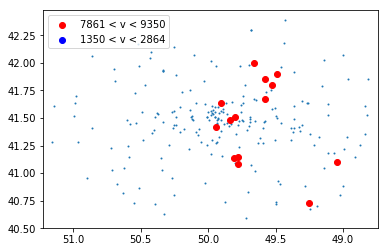

In [28]:
# plot all cluster members, and highlight the outliers
ra_min = numpy.min(ra[close_to_center])
ra_max = numpy.max(ra[close_to_center])
d_ra = ra_max-ra_min
fig = pl.figure()
ax=fig.add_subplot(111)
ax.set_xlim((ra_max+0.03*d_ra, ra_min-0.03*d_ra))
ax.scatter(ra[close_to_center], dec[close_to_center], s=1)
ax.scatter(ra[close_to_center][pos_offset_outliers], dec[close_to_center][pos_offset_outliers], 
           c='red', label='%d < v < %d' % ( (median_z + n_sigma*std_z), v_max))
ax.scatter(ra[close_to_center][neg_offset_outliers], dec[close_to_center][neg_offset_outliers], 
           c='blue', label='%d < v < %d' % ( v_min, (median_z - n_sigma*std_z)))
ax.legend()
#pl.close(fig)

In [18]:
# prepare histograms
n_bins=15
velocity_bins = numpy.linspace(v_min, v_max, n_bins-1)

[ 0.          0.01571901  0.01571901  0.02223003  0.02223003  0.03850355
  0.10426809  0.09029882  0.0666901   0.06851756  0.03850355  0.04446006
  0.04970786  0.02722612  0.04970786]


<Container object of 3 artists>

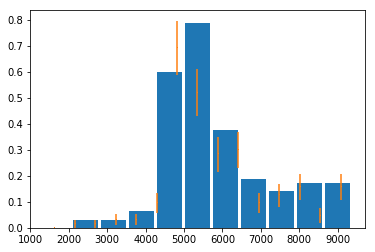

In [19]:
# also plot redshift histogram for the halo around perseus
halo_velocity = perseus_10deg.array['Velocity'][in_halo]

halo_hist,edges = numpy.histogram(
    halo_velocity,
    bins=n_bins, range=(v_min, v_max),
    weights=numpy.ones_like(halo_velocity, dtype=numpy.float)/halo_area,  
)
centers = 0.5*(edges[1:]+edges[:-1])

_halo_error,_ = numpy.histogram(
    halo_velocity,
    bins=n_bins, range=(v_min, v_max),
)
halo_error = numpy.sqrt(_halo_error)/halo_area
print halo_error

pl.hist(halo_velocity,
           bins=11, range=(v_min, v_max),
            density=False, weights=numpy.ones_like(halo_velocity, dtype=numpy.float)/halo_area,
            rwidth=0.9,
            label="halo",
           )
pl.errorbar(centers, halo_hist, yerr=halo_error, xerr=0, fmt=',')

Radius 0.00 .. 0.71 deg: 5273 +/- 1314 / N=175, density=111.41/sq.deg.
Radius 0.71 .. 1.00 deg: 5711 +/-  972 / N= 49, density= 31.19/sq.deg.
Radius 1.00 .. 1.41 deg: 5504 +/- 1523 / N= 66, density= 21.01/sq.deg.
Radius 1.41 .. 2.00 deg: 5255 +/- 1343 / N= 46, density=  7.32/sq.deg.
Radius 2.00 .. 2.83 deg: 5332 +/- 1359 / N= 41, density=  3.26/sq.deg.


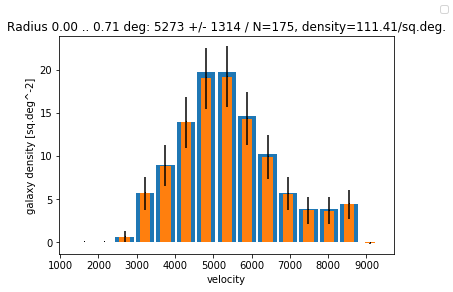

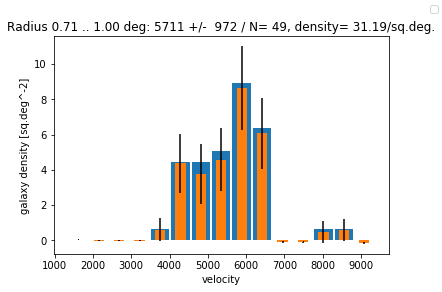

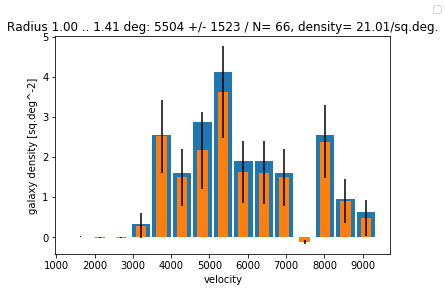

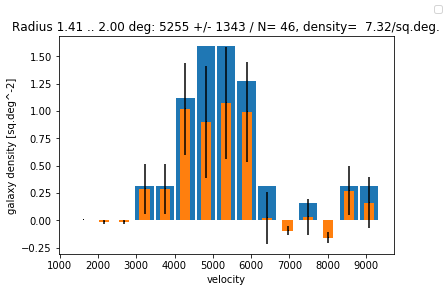

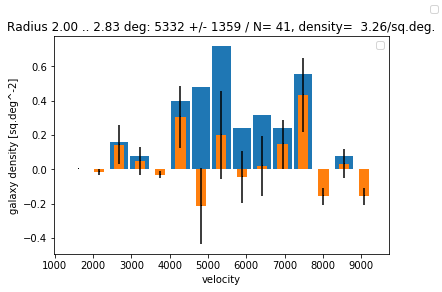

In [22]:
# plot velocity histogram in a number of radial bins

r_inner = 0

#for i, r_outer in enumerate([0.7,1,1.4,2.,2.8,4]):
for i, r_outer in enumerate(numpy.power(numpy.sqrt(2), numpy.arange(5)-1)):
    
    fig = pl.figure()
    ax = fig.add_subplot(111)
    
    in_ring = (d_center < astropy.coordinates.Angle(r_outer, unit='deg')) & \
              (d_center >= astropy.coordinates.Angle(r_inner, unit='deg'))
    redshifts_in_ring = numpy.array(member_redshifts[in_ring])
    _area = numpy.pi * (r_outer**2 - r_inner**2)
    
    hist,edges = numpy.histogram(redshifts_in_ring,
                               bins=n_bins, range=(v_min, v_max),
                               weights=numpy.ones_like(redshifts_in_ring, dtype=numpy.float)/_area,  
                               )
    _hist_error,_ = numpy.histogram(redshifts_in_ring, bins=n_bins, range=(v_min, v_max))
    # print numpy.sqrt(4)
    #hist_error = _hist_error
    hist_error = numpy.sqrt(_hist_error) / _area
    
    #print centers
    #print hist
    ax.bar(centers, hist, width=0.9*(edges[1]-edges[0]))
    # ax.errorbar(centers, hist, xerr=0, yerr=hist_error, fmt=',')
    
    ax.bar(centers, hist-halo_hist, width=0.5*(edges[1]-edges[0]))
    ax.errorbar(centers, hist-halo_hist, xerr=0, yerr=numpy.hypot(hist_error,halo_error), fmt=',', c='black')

    ax.set_xlabel("velocity")
    ax.set_ylabel("galaxy density [sq.deg^-2]")
#     ax.hist(redshifts_in_ring,
#            bins=11, range=(v_min, v_max),
#             density=False, weights=numpy.ones_like(redshifts_in_ring, dtype=numpy.float)/_area,
#             rwidth=0.9,
#             label="%.1f < r < %.1f" % (r_inner, r_outer),
#            )
    
    if (redshifts_in_ring.any()):
        _med_z = numpy.median(redshifts_in_ring)
        _std_z = numpy.std(redshifts_in_ring)
        _n_galaxies = redshifts_in_ring.shape[0]
        _density = _n_galaxies / _area
        title = "Radius %.2f .. %.2f deg: %4d +/- %4d / N=%3d, density=%6.2f/sq.deg." % (
            r_inner, r_outer, _med_z, _std_z, _n_galaxies, _density)
        print(title)
        ax.set_title(title)

    fig.legend()
    #fig.show()
    r_inner = r_outer
    #print
    
pl.legend()